In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from time import time
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split  # Needed to split the data
from Historic_Crypto import HistoricalData
from Historic_Crypto import Cryptocurrencies
from Historic_Crypto import LiveCryptoData
import yfinance as yf # Needed to utilize yfinance

In [2]:
print("Tensorflow version " + tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow version 2.1.0
Num GPUs Available:  0


In [3]:
class DDDQN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.d1 = tf.keras.layers.Dense(128, activation='relu')
        # we flatten our window to arrive at one prediction instead of one per window item.
        self.f1 = self.flatten = tf.keras.layers.Flatten()  
        self.d2 = tf.keras.layers.Dense(256, activation='relu')
        self.drop1 = tf.keras.layers.Dropout(0.5)
        self.d3 = tf.keras.layers.Dense(256, activation='relu')
        self.drop2 = tf.keras.layers.Dropout(0.5)
        # here's where the dueling architecture is different from DQN.
        # Instead of one node per action that would represent the Q value for each action, we split out the action and value into separate streams.
        self.dv1 = tf.keras.layers.Dense(64, activation='relu')
        self.da1 = tf.keras.layers.Dense(64, activation='relu')
        # the value is only one node. We want it to have no activation function, we want the raw expected value for the state (for example +1$ or -1$)
        self.dv2 = tf.keras.layers.Dense(1, activation=None) 
        # the advantage layer shows the advantage of each action we could take. again we want the raw value. 
        self.da2 = tf.keras.layers.Dense(3, activation=None) 

    def call(self, input_data):
        x = self.d1(input_data)
        x = self.f1(x)
        x = self.d2(x)
        x = self.drop1(x)
        x = self.d3(x)
        x = self.drop2(x)
        v = self.dv1(x)
        v = self.dv2(v)
        a = self.da1(x)
        a = self.da2(a)
        # Q is a linear combination of the value and advantage, part of our "dueling" architecture
        Q = v + (a - tf.math.reduce_mean(a, axis=1, keepdims=True))  
        return Q

    # this is the same as the call() method but only for the actions outputs
    def advantage(self, state):  
        x = self.d1(state)
        x = self.f1(x)
        x = self.d2(x)
        x = self.drop1(x)
        x = self.d3(x)
        x = self.drop2(x)
        a = self.da1(x)
        a = self.da2(a)
        return a

In [4]:
class ExpReplay():
    def __init__(self, num_features, window_size, buffer_size = 1000000):
        self.num_features = num_features
        self.buffer_size = buffer_size
        self.state_mem = np.zeros((self.buffer_size, self.num_features, window_size), dtype=np.float32)
        # ones because we use these as indices later when selecting an action from a list
        self.action_mem = np.ones((self.buffer_size), dtype=np.int32)  
        self.reward_mem = np.zeros((self.buffer_size), dtype=np.float32)
        self.next_state_mem = np.zeros((self.buffer_size, self.num_features, window_size), dtype=np.float32)
        # we want to make sure we are aware if we sample a terminal memory to zero out future expected rewards for this time step.
        self.done_mem = np.zeros((self.buffer_size), dtype=bool) 
        self.counter = 0

    def add_exp(self, state, action, reward, next_state, done):
        """
        Add the results of an action to the memory. Record the state before the action, the action we took to get there, the reward after the action, the next state, and whether the action ended the game.
        """
        # by using mod operator, we ensure we overwrite old data when the buffer is full. (1000001 % 1000000 = 1)
        pointer = self.counter % self.buffer_size
        self.state_mem[pointer] = state
        self.action_mem[pointer] = action
        self.reward_mem[pointer] = reward
        self.next_state_mem[pointer] = next_state
        # done is a bool, where 1 is True and 0 is false. We subtract it from 1 here because we multiply it by future rewards to zero-out future rewards in terminal states
        self.done_mem[pointer] = 1 - int(done)
        self.counter += 1

    def sample_exp(self, batch_size=64):
        max_mem = min(self.counter, self.buffer_size)  # get the amount of filled memory or total memory size, whichever is less.
        # get a list (batch) of random indices between 0 and the number of filled spots in memory (max_mem). batch_size shows that we want a list of 64 random indices. replace=false means that we can't sample the same memory index twice.
        batch = np.random.choice(max_mem, batch_size, replace=False)
        states = self.state_mem[batch] # sample 64 states from memory using the random indices we saved in "batch"
        actions = self.action_mem[batch]
        rewards = self.reward_mem[batch]
        next_states = self.next_state_mem[batch]
        dones = self.done_mem[batch]
        return states, actions, rewards, next_states, dones

In [5]:
class Agent():
    def __init__(self, data_shape, num_episodes, window_size=4, gamma=0.99, update_interval=96, lr=0.01, min_epsilon=0.02):
        self.window_size = window_size
        self.data_shape = data_shape
        self.inventory = []  
        self.gamma = gamma
        self.num_episodes = num_episodes
        self.epsilon = 1.0
        self.min_epsilon = min_epsilon
        self.update_interval = update_interval
        self.trainstep = 0
        self.memory = ExpReplay(self.window_size, data_shape[1])
        self.batch_size = 64
        self.online_net = DDDQN()
        self.target_net = DDDQN()
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
        self.online_net.compile(loss='mse', optimizer=opt)
        self.target_net.compile(loss='mse', optimizer=opt) # we won't ever optimize this network for loss, since we are only copying weights from our online network every 100 steps

    def get_action(self, state):
        # create a random number between 0 and 1 and compare it to epsilon for our epsilon-greedy algorithm
        if tf.random.uniform([]) <= self.epsilon:
            # Select a random action out of the list of available actions
            if len(self.inventory) > 0:  # if we have inventory to sell
                return np.random.choice([0, 1, 2])
            else:
                return np.random.choice([1, 2])
        else:
            # Select the action with the highest Q-value
            actions = self.online_net.advantage(np.array([state]))[0]
            if len(self.inventory) > 0:
                action = tf.math.argmax(actions, axis=0).numpy()
            else: # if we don't have inventory to sell, we remove that action option
                action = tf.math.argmax(actions[1:], axis=0).numpy() + 1 # + 1 here since we removed the first item and we need to maintain the original list indices
            return action
    
    def update_target(self):
        self.target_net.set_weights(self.online_net.get_weights()) # copies the weights of our target DQN from our online DQN (copies the network)

    def update_epsilon(self):
        if self.epsilon > self.min_epsilon:
            b = self.min_epsilon**(1/(self.num_episodes*self.data_shape[0]))
            self.epsilon = b**self.trainstep

    def train(self):
        # if we haven't filled our batch of 64 with enough experiences to fill our memory yet, we don't train our model. This way we don't train our model every single action, just every 64.
        if self.memory.counter < self.batch_size: 
            return 
        
        # every 100 steps, we update our target network. the 100 is set in the update_interval variable. This prevents us form "chasing our own tail", and improves the stability of our Deep Q Learning.
        if self.trainstep % self.update_interval == 0: 
            self.update_target()
        
        # Here we use experience replay buffers to sample our memory of past experiences.
        # In contrast to consuming samples online and discarding them thereafter, sampling from the stored experiences means they are less heavily correlated and can be re-used for learning.
        # Can we improve this with Prioritized Experience Replay? It improves by weighing the importance of different memories differently.
        states, actions, rewards, next_states, dones = self.memory.sample_exp(self.batch_size) # we sample 64 experiences from our memory since we are training in batches of 64 and not every time
        
        # feed-forward:
        # We calculate the possible Q values with our online network, then we calculate again the Q values with our target network and find which action has the highest Q value. (this is where double DQN comes in)
        # We then select the action with the best Q value determined by our online network, and use the Q value from the corresponding action in our target network to train our online network (minimizing loss).
        q_next_state_online_net = self.online_net.predict(next_states, verbose=0)  # equivalent to __call__()
        q_next_state_target_net = self.target_net.predict(next_states, verbose=0)
        
        max_action = tf.math.argmax(q_next_state_online_net, axis=1, output_type=tf.dtypes.int32).numpy()
        # Now that we know which action provided the maximum Q value according to our online network, we can train our online model using the Q value from the corresponding action in our target network.
        # 1. We predict the Q values for the action we actually took using our online network and save the values in q_predicted
        # 2. we copy q_predicted to q_target because of how Keras/TF calculates loss (we have to copy it to a fresh variable). By using np.copy, we zero out all losses associated with actions not taken  
        # 3. We update the Q values of q_target with the rewards we got from the action we actually took and the future value according to our target network (gamma, our discount rate, time the next step Q value)
        # 4. We update the weights of our online network by training it using this ^

        batch_index = tf.range(self.batch_size, dtype=tf.dtypes.int32)

        q_predicted = self.online_net.predict(states, verbose=0) # in our equation for the optimal Q function, we need to know the value of the action we actually took.
        q_target = np.copy(q_predicted) # We copy q_predicted to q_target because of how Keras/TF calculates loss. By using np.copy, we basically zero out all losses associated with actions not taken 

        # The Q value for each state in our batch, for the action we ACTUALLY took, is equal to the reward for that time step plus gamma times the Q value of the next step, according to our target network.
        # this q_target is the Q value we are chasing after with our estimates. It is the estimated "optimal" Q value based on the Bellman equation.
        q_target[batch_index, actions] = rewards + self.gamma * q_next_state_target_net[batch_index, max_action] * dones # if a state is done, done has been set to 0. This is because the expected future rewards for a terminal state is always 0.
                # ^ we subset our q_target array (remember: this is actually a copy of our predictions from the online network) by selecting 64 entries according to batch_index, then the best action according to actions.
                # it returns a 1d array of 64 elements with the best action per memory entry in the batch, which we replace with the reward and expected outcome according to our target network

        loss = self.online_net.train_on_batch(states, q_target)
        self.update_epsilon()
        self.trainstep += 1
        return loss

    def save_model(self):
        self.online_net.save("online_model.h5")
        self.target_net.save("target_model.h5")

    def trade(self, t, action, eth_df, balance):
        reward = 0
        if action == 0:
            # print("SELL")
            reward = eth_df["Close"].iloc[t] - self.inventory.pop(0) 
        elif action == 1:
            # print("HOLD")
            pass
        elif action == 2 and balance >= eth_df["Close"].iloc[t]:
            # print("BUY")
            self.inventory.append(eth_df["Close"].iloc[t])
        return reward
    
    def get_state(self, t, eth_df):
        num_rows = t - self.window_size + 1
        if num_rows >= 0:
            window = eth_df.iloc[num_rows : t + 1]
        else:
            repeated_first_row = pd.concat([pd.DataFrame(np.repeat(eth_df.iloc[[0]].values, -num_rows, axis=0), columns=eth_df.columns)])
            new_data = eth_df.iloc[0 : t + 1]
            window = pd.concat([repeated_first_row, new_data], ignore_index=True)  # prevents us from sampling data that doesn't exist at the start.
        return window

In [6]:
def get_crypto_data(start_date, end_date, split_date):
    try:
        train = pd.read_csv("train.csv", index_col=0)
        test = pd.read_csv("test.csv", index_col=0)
    except:
        df = HistoricalData('ETH-USD', 3600, start_date, end_date).retrieve_data()  # 3600 is the interval in seconds which is 1 hour
        split_row = df.index.get_loc(split_date)
        cols = df.columns.tolist()
        df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=cols)
        train = df[:split_row]
        test = df[split_row:]
        train.to_csv("train.csv")
        test.to_csv("test.csv")
    return train, test

In [7]:
# pre-collected data
def get_precollected_data(split_ratio=0.8):
    # try:
    historic_data = pd.read_csv("combined_data.csv", index_col=0)
    print('Pre-collected data loaded successfully.')
    # convert date to datetime if it isn't the index
    if historic_data.index.name != 'Date':
        historic_data['Date'] = pd.to_datetime(historic_data['Date'], infer_datetime_format=True)
        print('Date converted to datetime.')
        # set date as index
        historic_data = historic_data.set_index('Date')
        print('Date set as index.')
    # drop nan values
    historic_data = historic_data.dropna()
    print('NaN values dropped.')
    cols = historic_data.columns.tolist()
    df = pd.DataFrame(MinMaxScaler().fit_transform(historic_data), columns=cols)
    print('Data scaled.')
    train, test = train_test_split(df, train_size=split_ratio,shuffle=False)
    print('Data split.')
    train.to_csv("train.csv")
    print('Train data saved.')
    test.to_csv("test.csv")
    print('Test data saved.')
    return train, test
        
    # except:
    #     # throw error
    #     print("No pre-collected data found. Please run the data collection script first.")
    #     exit()

In [8]:
historic_data = pd.read_csv("combined_data.csv", index_col=0)

historic_data.head()

,Bitcoin,Crypto,Cryptocurrency,ETH,Crytpo Regulations,Crypto Ban,Crypto Bubble,Bull,Bear,Hack,...,7day_Past_Mean_Price,Yesterday_Volume,3day_Past_Mean_Volume,7day_Past_Mean_Volume,Yesterday_Vol_USDT,3day_Past_Mean_Vol_USDT,7day_Past_Mean_Vol_USDT,RSI,RSI_BuySellFlag,EMA_BuySellFlag
Date,,,,,,,,,,,,,,,,,,,,,
12/6/2017,27,2,3,1,0,1,0,21,90,45,...,11638.91420,6.895260e+09,8.561323e+09,7.503513e+09,8.141460e+08,9.213820e+08,8.834587e+08,96.377874,0,1
12/7/2017,55,3,4,1,0,0,0,19,83,41,...,12734.07129,1.265630e+10,1.250075e+10,8.880657e+09,1.281490e+09,1.255749e+09,9.731216e+08,97.951281,0,0
12/8/2017,83,2,4,1,0,0,0,17,85,53,...,13533.18569,1.795070e+10,1.724767e+10,1.093107e+10,1.671610e+09,1.648710e+09,1.150784e+09,83.542472,0,0
12/9/2017,59,2,5,1,0,3,0,71,81,37,...,14119.41434,2.113600e+10,1.766600e+10,1.218433e+10,1.993030e+09,1.754517e+09,1.282064e+09,71.669077,0,0
12/10/2017,47,3,4,1,0,2,0,77,95,49,...,14709.72866,1.391130e+10,1.616020e+10,1.315932e+10,1.598910e+09,1.747147e+09,1.382457e+09,72.507514,0,0


In [9]:
STARTING_BALANCE = 100
NUM_EPISODES = 30
START_DATE = "2017-01-01-00-00"
END_DATE = "2022-07-22-00-00"
TESTING_SPLIT = "2022-01-01 00:00:00" # formatting is different here because of how historic_crypto indexes dataframes

In [10]:
def main():
    # train_df, test_df = get_crypto_data(START_DATE, END_DATE, TESTING_SPLIT)
    train_df, test_df = get_precollected_data(split_ratio=0.8)
    trading_agent = Agent(train_df.shape, NUM_EPISODES, window_size=48, gamma=0.95, update_interval=96, lr=0.01, min_epsilon=0.02)
    episode_mem = [{"Actions": [], "Inventory Size": [], "Portfolio Value": [], "Realized Profit": [], "Reward": [], "Done": [], "Epsilon": [], "MSE Loss": []} for i in range(NUM_EPISODES)]
    t0 = time()

    ######################## Training ########################
    for s in range(NUM_EPISODES):
        print(f"\n===== Episode {s + 1} / {NUM_EPISODES} =====")
        state = trading_agent.get_state(0, train_df)
        balance = STARTING_BALANCE
        done = False
        for t in range(len(train_df) - 1):
            if done:
                break
            action = trading_agent.get_action(state)
            next_state = trading_agent.get_state(t + 1, train_df)
            reward = trading_agent.trade(t, action, train_df, balance)
            balance += reward
            done = balance < train_df["Close"].iloc[t]
            trading_agent.memory.add_exp(state, action, reward, next_state, done)
            loss = trading_agent.train()
            if not loss:
                loss = 0
            state = next_state

            episode_mem[s]["Actions"].append(int(action))
            episode_mem[s]["Inventory Size"].append(len(trading_agent.inventory))
            episode_mem[s]["Portfolio Value"].append(float(balance + train_df["Close"].iloc[t] * len(trading_agent.inventory) - sum(trading_agent.inventory)) - STARTING_BALANCE)
            episode_mem[s]["Realized Profit"].append(float(balance - STARTING_BALANCE))
            episode_mem[s]["Reward"].append(float(reward))
            episode_mem[s]["Done"].append(bool(done))
            episode_mem[s]["Epsilon"].append(trading_agent.epsilon)
            episode_mem[s]["MSE Loss"].append(float(loss))

            if t % 100 == 0:
                print(f"Time step {t} / {len(train_df)}   |   Portfolio Value: {round(episode_mem[s]['Portfolio Value'][t], 3)}   |   Inventory: {len(trading_agent.inventory)}   |   ETH$: {round(train_df['Close'].iloc[t], 3)}   |   Epsilon: {round(trading_agent.epsilon, 4)}   |   MSE Loss: {loss}")

        with open('training_scores.out', 'a') as f:
            f.write(f"EPISODE {s} (runtime: {time() - t0})   |   Profit is {balance - STARTING_BALANCE}, and epsilon is {trading_agent.epsilon}\n")

    with open('episode_mem.json', 'w') as f:
        json.dump(episode_mem, f)

    ######################## Testing ########################
    t0 = time()
    testing_mem = {"Actions": [], "Inventory Size": [], "Portfolio Value": [], "Realized Profit": [], "Reward": [], "Done": []}
    trading_agent.epsilon = 0
    state = trading_agent.get_state(0, test_df)
    balance = STARTING_BALANCE
    done = False
    for t in range(len(test_df) - 1):
        if done:
            break
        action = trading_agent.get_action(state)
        next_state = trading_agent.get_state(t + 1, test_df)
        reward = trading_agent.trade(t, action, test_df, balance)
        balance += reward
        done = balance < test_df["Close"].iloc[t]
        state = next_state

        testing_mem["Actions"].append(int(action))
        testing_mem["Inventory Size"].append(len(trading_agent.inventory))
        testing_mem["Portfolio Value"].append(float(balance + test_df["Close"].iloc[t] * len(trading_agent.inventory) - sum(trading_agent.inventory)) - STARTING_BALANCE)
        testing_mem["Realized Profit"].append(float(balance - STARTING_BALANCE))
        testing_mem["Reward"].append(float(reward))
        testing_mem["Done"].append(bool(done))

        if t % 100 == 0:
            print(f"Time step {t} / {len(test_df)}   |   Portfolio Value: {round(testing_mem['Portfolio Value'][t], 3)}   |   Inventory: {len(trading_agent.inventory)}   |   ETH$: {round(test_df['Close'].iloc[t], 3)}   |   MSE Loss: {loss}")

    balance += train_df["Close"].iloc[t] * len(trading_agent.inventory) - sum(trading_agent.inventory)

    with open('testing_scores.out', 'a') as f:
        f.write(f"TESTING (runtime: {time() - t0})   |   Profit is {balance - STARTING_BALANCE}")

    with open('testing_mem.json', 'w') as f:
        json.dump(testing_mem, f)

if __name__ == "__main__":
    main()

Pre-collected data loaded successfully.
NaN values dropped.
Data scaled.
Data split.
Train data saved.
Test data saved.

===== Episode 1 / 30 =====
Time step 0 / 1432   |   Portfolio Value: 0.0   |   Inventory: 1   |   ETH$: 0.172   |   Epsilon: 1.0   |   MSE Loss: 0
Time step 100 / 1432   |   Portfolio Value: -0.46   |   Inventory: 2   |   ETH$: 0.079   |   Epsilon: 0.9966   |   MSE Loss: 0.0012483310420066118

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Time step 200 / 1432   |   Portfolio Value: -0.721   |   Inventory: 5   |   ETH$: 0.046   |  

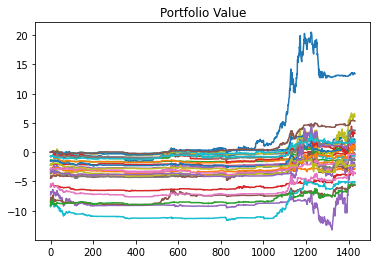

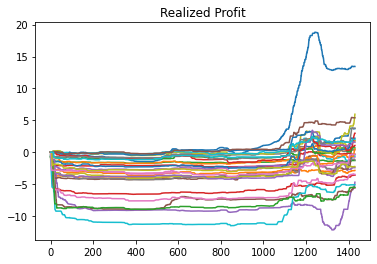

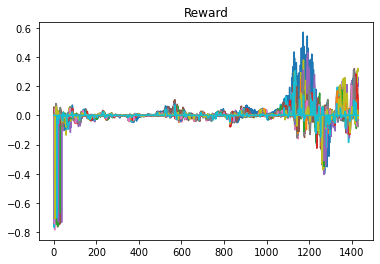

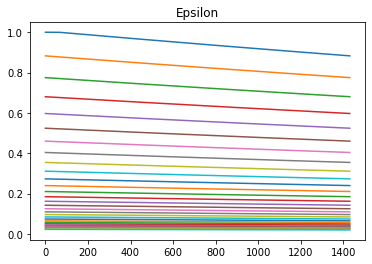

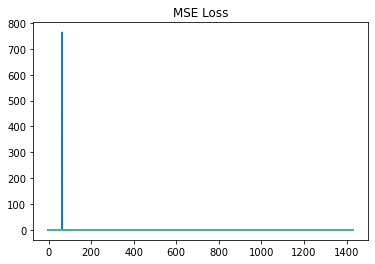

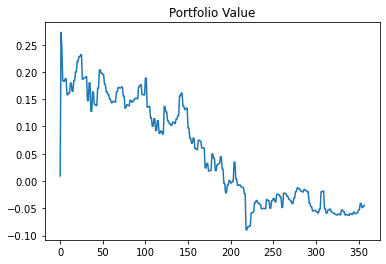

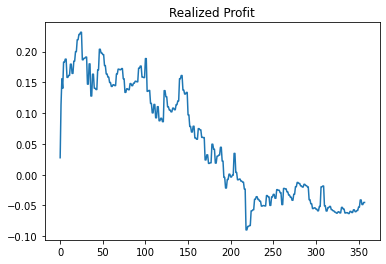

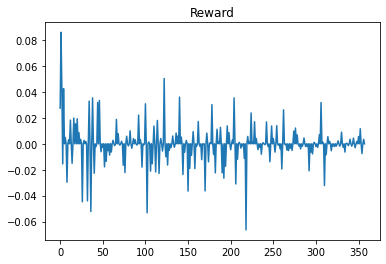

In [12]:
import matplotlib.pyplot as plt

# visualize training data
with open('episode_mem.json', 'r') as f:
    episode_mem = json.load(f)

for i in range(NUM_EPISODES):
    plt.plot(episode_mem[i]["Portfolio Value"])
plt.title("Portfolio Value")
plt.show()

for i in range(NUM_EPISODES):
    plt.plot(episode_mem[i]["Realized Profit"])
plt.title("Realized Profit")
plt.show()

for i in range(NUM_EPISODES):
    plt.plot(episode_mem[i]["Reward"])
plt.title("Reward")
plt.show()

for i in range(NUM_EPISODES):
    plt.plot(episode_mem[i]["Epsilon"])
plt.title("Epsilon")
plt.show()

for i in range(NUM_EPISODES):
    plt.plot(episode_mem[i]["MSE Loss"])
plt.title("MSE Loss")
plt.show()

# visualize testing data
with open('testing_mem.json', 'r') as f:
    testing_mem = json.load(f)

plt.plot(testing_mem["Portfolio Value"])
plt.title("Portfolio Value")
plt.show()

plt.plot(testing_mem["Realized Profit"])
plt.title("Realized Profit")
plt.show()

plt.plot(testing_mem["Reward"])
plt.title("Reward")
plt.show()